In [3]:
import datetime 
import pathlib

import pandas as pd
import polars as pl

CONSOLIDATED_DIR = pathlib.Path('data/dynamicrouting_datacube_v0.0.268/consolidated')
session_table = 'data/dynamicrouting_datacube_v0.0.268/session_table.parquet'

---
## Nullable data types

In pandas dataframes, we can't represent missing values in integer columns: instead the whole column is converted to float dtype:

In [8]:
pd.DataFrame({'stim_number': [0, 1, 2]})

,stim_number
0,0
1,1
2,2


In [32]:
pd.DataFrame({'stim_number': [0, 1, 2, None]})

,stim_number
0,0.0
1,1.0
2,2.0
3,NaN


This is just a quirk of how numpy works, and pandas is built on top of numpy:

In [41]:
import numpy as np

np.array([0, 1, 2]).dtype, np.array([0, 1, 2, None]).dtype

(dtype('int64'), dtype('O'))

We see the same behavior with boolean columns, where the whole column will also be converted to `object` dtype:

In [ ]:
np.array([True, False]).dtype, np.array([True, False, None]).dtype

pandas 2.0 introduced optional usage of Arrow data types instead of numpy, in which all data types are nullable.

However, when creating a new DataFrame, it's only possible to specify the dtype of the entire
DataFrame, not individual columns, which is limits the usefulness: 

In [36]:
pd.DataFrame({'stim_number': [0, 1, 2, None]}, dtype='int16[pyarrow]')

,stim_number
0,0
1,1
2,2
3,<NA>


In [44]:
np.array([True, False, None]).dtype

dtype('O')

polars is built on top of Arrow, so it has nullable data types by default:

(we can also specify the
dtype of individual columns when creating a DataFrame in case we want something other than the
default, which would be int64 in this case)

In [47]:
pl.DataFrame({'stim_number': [0, 1, 2, None]}, schema={'stim_number': pl.UInt16})

stim_number
u16
0
1
2
null


---

## No index

In pandas, we generally use and index to refer to rows or use a Boolean mask to filter rows, which relies on the order of rows to not change.

In polars, we don't have an index, and instead we use expressions to refer to columns in the DataFrame and their values, indpendent of the order of rows.

This is similar to the pandas `.query()` method, but with a more comprehensive functionality.

Here are the basics:


In [66]:
df  = pl.DataFrame(
    {
        'stim_number': [0, 1, 2, None], 
        'stim_name': ['a', 'a', 'b', 'a'],
    }
)

In [ ]:
(
    df
    .filter(
        # all comma-separated expressions are combined with AND
        # so the following keep rows that meet both conditions:
        pl.col('stim_name') == 'a',
        pl.col('stim_number') > 0,
    )
)

stim_number,stim_name
i64,str
1,"""a"""


In [69]:
(
    df
    .filter(
        # we can do OR operations to keep rows that fulfil either condition below:
        (pl.col('stim_name') == 'a') | (pl.col('stim_number') > 0),
        # plus an additional condition:
        pl.col('stim_number').is_not_null(),
    )
)

stim_number,stim_name
i64,str
0,"""a"""
1,"""a"""
2,"""b"""


(the `pl.col()` function is explained further below)

---

## Polars queries

Here's a typical operation in polars using real data in parquet files. 

Try commenting out all but the first line, then add back one method at a time to see how what the output looks like at each step:

In [53]:
(
    pl.read_parquet(CONSOLIDATED_DIR / 'session.parquet')
    .join(
        pl.read_parquet(CONSOLIDATED_DIR / 'performance.parquet'),
        on='session_id',
        how='left',
    )
    .filter(
        pl.col('keywords').list.contains('production'),
    )
    .group_by('session_id')
    .agg(
        pl.all(), # <-- all columns will be retained, and the values for each session will be turned into a list 
        pl.col('signed_cross_modality_dprime').mean().alias('mean_signed_cross_modality_dprime'),
    )
    .filter(
        pl.col('mean_signed_cross_modality_dprime') > 2.0,
    )
    .with_columns(
        (pl.col('stop_time') - pl.col('start_time')).alias('block_duration'),
    )
    .select(
        'block_index', 
        'block_duration',
        'signed_cross_modality_dprime',
        pl.col('subject_id').list.first(), # since all subject_id are the same for a particular session, we can use the first entry in the list
    )
    .explode('block_index', 'block_duration', 'signed_cross_modality_dprime')
    .sort('block_index')
)

block_index,block_duration,signed_cross_modality_dprime,subject_id
i64,f64,f64,i64
0,603.68899,2.224615,703880
1,601.10347,1.769163,703880
2,604.8567,2.639312,703880
3,602.07098,2.102846,703880
4,605.50716,2.626949,703880
5,597.18357,1.232238,703880


### Streamlined version

We can write the query above without the group_by/agg operation, which is easier to
read and doesn't require us to deal with list columns:

In [ ]:
(
    pl.read_parquet(CONSOLIDATED_DIR / 'session.parquet')
    .join(
        pl.read_parquet(CONSOLIDATED_DIR / 'performance.parquet'),
        on='session_id',
        how='left',
    )
    .filter(
        pl.col('keywords').list.contains('production'),
        pl.col('signed_cross_modality_dprime').mean().over('session_id') > 2.0, # <-- for each row, only consider the other rows with the same session_id
    )
    .with_columns(
        (pl.col('stop_time') - pl.col('start_time')).alias('block_duration'),
    )
    .select('block_index', 'block_duration', 'signed_cross_modality_dprime', 'subject_id')
    .sort('block_index')
)

block_index,block_duration,signed_cross_modality_dprime,subject_id
i64,f64,f64,i64
0,603.68899,2.224615,703880
1,601.10347,1.769163,703880
2,604.8567,2.639312,703880
3,602.07098,2.102846,703880
4,605.50716,2.626949,703880
5,597.18357,1.232238,703880


---
## Expressions

In the queries above, we used the `pl.col()` to refer to columns in the DataFrame.
This is a powerful feature of polars that allows us to build complex queries using expressions alone, rather than DataFrame methods.

- expressions are independent of the DataFrame, and can be used to build queries that can be applied to any DataFrame: the column names are resolved at query time, not when the expression is created
- expressions are composable and reusable

In [60]:
from polars import Expr


dprime_col: Expr = pl.col('signed_cross_modality_dprime')
dprime_expr: Expr = dprime_col.mean().over('session_id') > 2.0

dprime_expr

<Expr ['[(col("signed_cross_modality_d…'] at 0x1778C5CBB50>

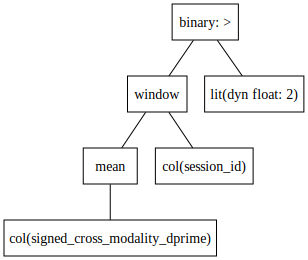

In [61]:
dprime_expr.meta.show_graph()

Expressions can also be serialized, which can be useful for configuring analysis pipelines or for reproducibility:

In [62]:
norm_expr.meta.serialize(format='json')

'{"Function":{"input":[{"Function":{"input":[{"Eval":{"expr":{"Column":"coords"},"evaluation":{"Function":{"input":[{"Column":""},{"Literal":{"Dyn":{"Int":2}}}],"function":{"Pow":"Generic"}}},"variant":"List"}}],"function":{"ListExpr":"Sum"}}}],"function":{"Pow":"Sqrt"}}}'

All of the operaters (> < = != & | etc.) are also available as methods on the `pl.Expr` object,
which can avoid writing many parentheses, but is arguably less readable:

In [ ]:
pl.col('stim_name').eq('a')
pl.col('stim_number').sum().gt(1).over('stim_name')

---
## Lazy evaluation

A powerful feature of polars is it's high-performance query engine, written in Rust, which optimizes queries before executing them.
We can write queries with multiple operations and polars will figure out the most efficient way to execute them.

When using a `DataFrame`, this is done seemlessly. Behind the scenes, polars uses a `LazyFrame` to build a query plan. 
We can also create and use `LazyFrame` objects directly, which allows us to build queries that only read in the minimal amount of data required.

For example, where we previously used `pl.read_parquet()` to load all data in a file into memory as a `DataFrame`, we now use `pl.scan_parquet()` to create a `LazyFrame`:

In [ ]:
lf = pl.scan_parquet(CONSOLIDATED_DIR / 'performance.parquet')

lf

At this stage, there is no data, just metadata and a query plan, which says to simply read all 25
columns.

If we try to get data from the `LazyFrame` it will fail:

In [73]:
lf['session_id']

TypeError: LazyFrame is not subscriptable (aside from slicing)

Use `select()` or `filter()` instead.

We can otherwise treat a `LazyFrame` like a `DataFrame`, but it will not execute the query until we
call `.collect()` to materialize the data. 

It will, however, alert us if we try to access a column that doesn't exist:

In [ ]:
(
    pl.scan_parquet(CONSOLIDATED_DIR / 'performance.parquet')
    .filter(
        pl.col('keywords').list.contains('production'),
        pl.col('signed_cross_modality_dprime').mean().over('session_id') > 2.0, # <-- for each row, only consider the other rows with the same session_id
    )
    .with_columns(
        (pl.col('stop_time') - pl.col('start_time')).alias('block_duration'),
    )
    .select('block_index', 'block_duration', 'signed_cross_modality_dprime', 'subject_id')
    .sort('block_index')
)

ColumnNotFoundError: unable to find column "keywords"; valid columns: ["start_time", "stop_time", "block_index", "n_trials", "n_responses", "n_hits", "n_contingent_rewards", "hit_rate", "false_alarm_rate", "catch_response_rate", "rewarded_modality", "is_first_block_aud", "cross_modality_dprime", "signed_cross_modality_dprime", "vis_dprime", "aud_dprime", "vis_target_response_rate", "vis_nontarget_response_rate", "aud_target_response_rate", "aud_nontarget_response_rate", "session_idx", "date", "subject_id", "session_id", "id"]

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sort' <---
Parquet SCAN [data\dynamicrouting_datacube_v0.0.268\consolidated\performance.parquet] [id: 3239446728752]
PROJECT */25 COLUMNS

After removing the offending query, we can see the complete query plan.
Try toggling `.collect()` to see the actual data:

In [83]:
lf = (
    pl.scan_parquet(CONSOLIDATED_DIR / 'performance.parquet')
    .filter(
        pl.col('signed_cross_modality_dprime').mean().over('session_id') > 2.0, # <-- for each row, only consider the other rows with the same session_id
    )
    .with_columns(
        (pl.col('stop_time') - pl.col('start_time')).alias('block_duration'),
    )
    .select('block_index', 'block_duration', 'signed_cross_modality_dprime', 'subject_id')
    .sort('block_index')
)
lf

When we examine the optimized query plan, we can see that polars will only read 6/25 columns from
the parquet file:

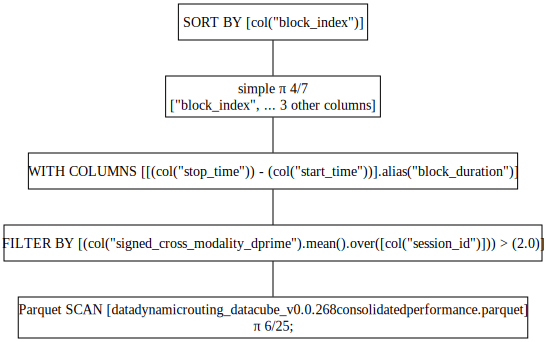

In [84]:
lf.show_graph()

With parquet files, each column is stored in chunks with metadata about the min/max values, so if
there's filtering operation in the query, polars can skip reading the chunks that don't match the
filter to read even less data. 

This is referred to as **predicate pushdown**.

It reduces memory usage and allows us to work with datasets that are larger than the amount of RAM
available.

It also makes queries against files on S3 more efficient, since we're downloading less data.

Finally, to get the data as a regular `DataFrame`, we just have to call `.collect()` on the `LazyFrame`, at
which point polars fetches the necessary data from the parquet files:

In [86]:
lf.collect()

block_index,block_duration,signed_cross_modality_dprime,subject_id
i64,f64,f64,i64
0,603.68899,2.224615,703880
1,601.10347,1.769163,703880
2,604.8567,2.639312,703880
3,602.07098,2.102846,703880
4,605.50716,2.626949,703880
5,597.18357,1.232238,703880


In [2_lazynwb.ipynb](2_lazynwb.ipynb) we'll see how to access NWB files with the same `LazyFrame`
interfact, so we can build queries that read data efficiently.